In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle

import torch
import torch.nn.functional as F

In [2]:
with uproot.open("../pythia/output/dataset_ttbar_mu60_NumEvents10000_MinJetpT25.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    trk_pt = f["trk_pT"].array()
    trk_eta = f["trk_eta"].array()
    trk_phi = f["trk_phi"].array()
    trk_q = f["trk_q"].array()
    trk_d0 = f["trk_d0"].array()
    trk_z0 = f["trk_z0"].array()
    trk_label = f["trk_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()
    jet_pufr_truth = f["jet_pufr_truth"].array()

In [3]:
%%time
num_events = len(jet_pt)
trk_feats = []
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    idx_list = list(jet_trk_IDX[event])
    idx_list.append(len(trk_pt[event]))
    
    jet_trk_feats = []
    for i in range(len(idx_list)-1):
        start_idx = idx_list[i]
        end_idx = idx_list[i+1]
        trk_pt_tmp = np.array(trk_pt[event][start_idx:end_idx])
        trk_eta_tmp = np.array(trk_eta[event][start_idx:end_idx])
        trk_phi_tmp = np.array(trk_phi[event][start_idx:end_idx])
        trk_q_tmp = np.array(trk_q[event][start_idx:end_idx])
        trk_d0_tmp = np.array(trk_d0[event][start_idx:end_idx])
        trk_z0_tmp = np.array(trk_z0[event][start_idx:end_idx])
        trk_label_tmp = np.array(trk_label[event][start_idx:end_idx])

        feats = [trk_pt_tmp, trk_eta_tmp, trk_phi_tmp, trk_q_tmp,
                trk_d0_tmp, trk_z0_tmp, trk_label_tmp]
        feats = np.stack(feats, axis=-1)
        jet_trk_feats.append(feats)
    
    trk_feats.append(jet_trk_feats)
    
trk_feats = ak.Array(trk_feats)

print("Processing: ", num_events, " / ", num_events)
print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Processing:  10000  /  10000
Num Events:  10000
Num Jets in first event:  22
Num Tracks in first event first jet:  82
Num Tracks features:  7
CPU times: user 3min 53s, sys: 1.76 s, total: 3min 55s
Wall time: 3min 54s


In [4]:
%%time
num_events = len(jet_pt)
jet_feats = []
for event in range(num_events):
    jet_corrJVF_tmp = np.array(jet_corrJVF[event])
    jet_RpT_tmp = np.array(jet_RpT[event])
    jet_pt_tmp = np.array(jet_pt[event])
    jet_eta_tmp = np.array(jet_eta[event])
    jet_phi_tmp = np.array(jet_phi[event])
    jet_m_tmp = np.array(jet_m[event])
    jet_pufr_truth_tmp = np.array(jet_pufr_truth[event])

    feats = [jet_pt_tmp, jet_eta_tmp, jet_phi_tmp, jet_m_tmp, jet_corrJVF_tmp, jet_RpT_tmp, jet_pufr_truth_tmp]
    feats = np.stack(feats, axis=-1)
    
    jet_feats.append(feats)
    
jet_feats = ak.Array(jet_feats)

print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

Num Events:  10000
Num Jets in first event:  22
Num Jet Features:  7
CPU times: user 11.5 s, sys: 40.2 ms, total: 11.6 s
Wall time: 11.5 s


In [5]:
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

trk_q_cut = selected_tracks[:,:,:,3]!=0          # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4        # 400MeV Cut

mask = trk_q_cut & trk_eta_cut & trk_pt_cut

refined_tracks = selected_tracks[mask]

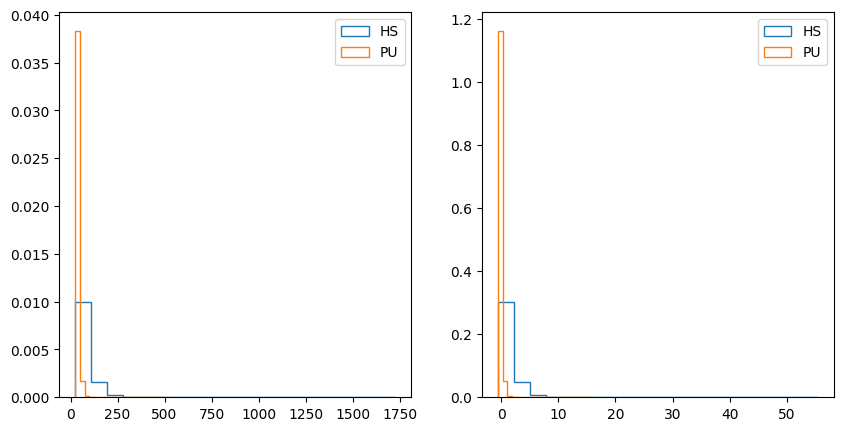

Mean Before:  43.01074871556878 		 Mean After:  -9.932060214457382e-17
STD Before:  30.348506484810255 		 STD After:  0.9999999999998069


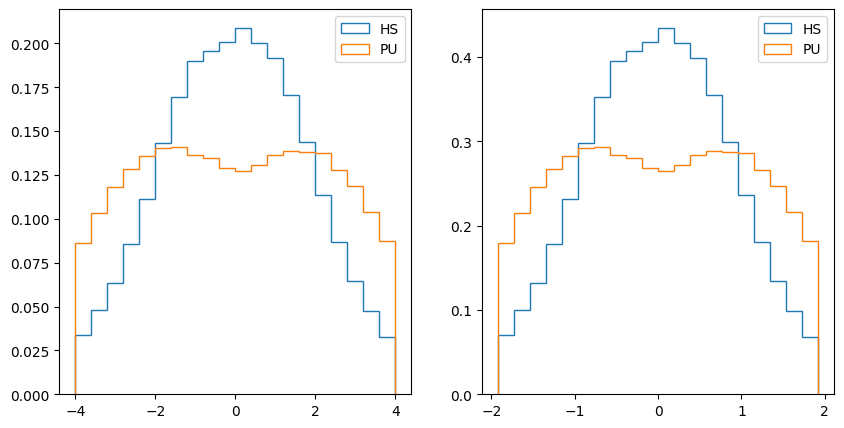

Mean Before:  0.000526523227506125 		 Mean After:  1.4021673145861718e-17
STD Before:  2.0811860018060493 		 STD After:  0.9999999999999306


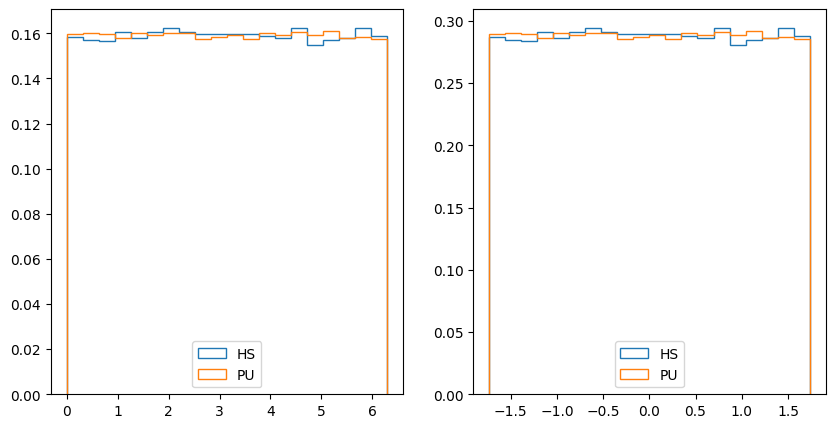

Mean Before:  3.139369774377156 		 Mean After:  1.2770674125519835e-16
STD Before:  1.8129158626897437 		 STD After:  0.9999999999996585


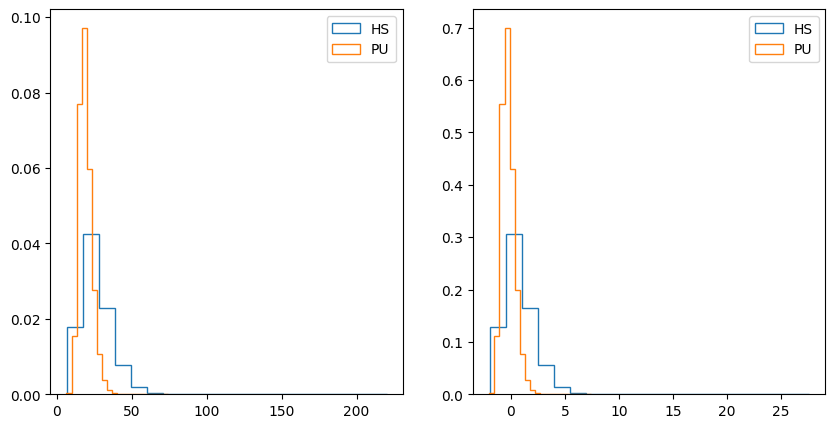

Mean Before:  20.85082197709769 		 Mean After:  -1.2479467174008568e-16
STD Before:  7.201558404986072 		 STD After:  0.9999999999992996


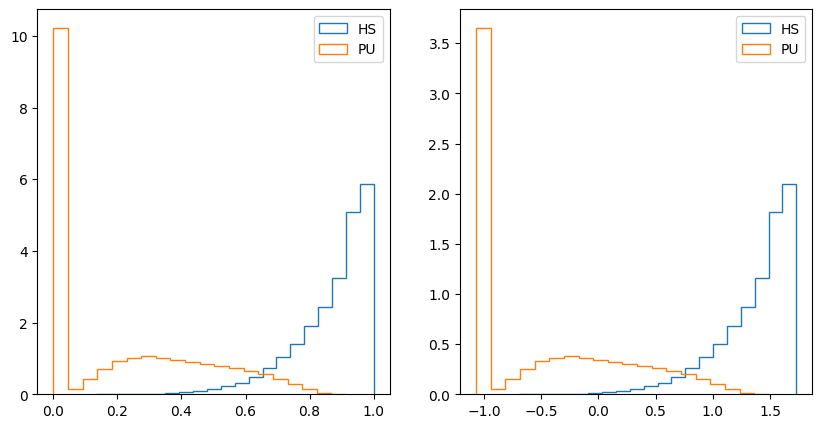

Mean Before:  0.38170667011195325 		 Mean After:  2.456666472793342e-15
STD Before:  0.35732404454839267 		 STD After:  0.9999999999991169


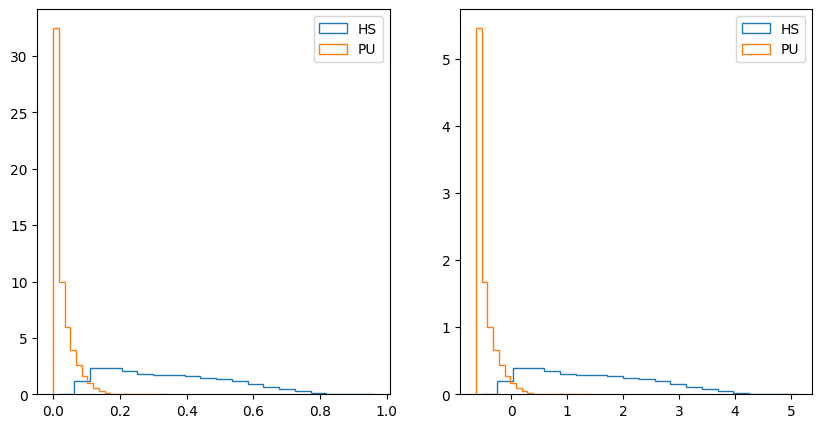

Mean Before:  0.10523359576358746 		 Mean After:  3.7467088161334714e-17
STD Before:  0.16801109033508846 		 STD After:  1.0000000000005373


In [6]:
num_jet_feats = len(selected_jets[0][0])-1

sig = selected_jets[:,:,-1]<0.7
bkg = ~sig

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
# Append Labels
norm_list.append(selected_jets[:,:,-1])

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

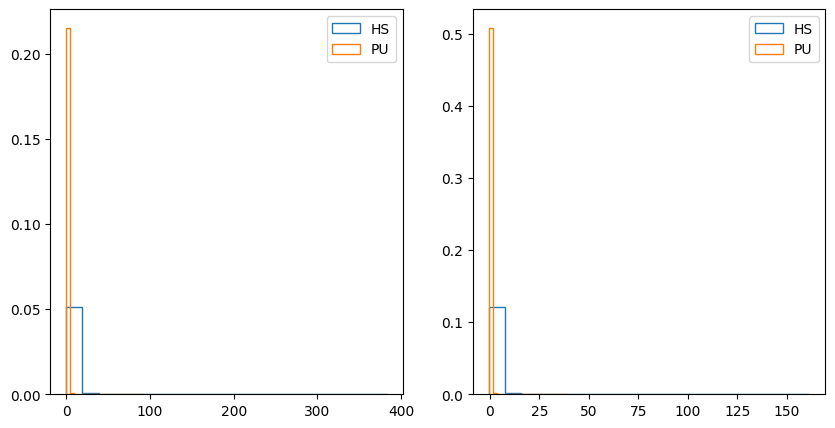

Mean Before:  1.2520514342436564 		 Mean After:  -4.2063797383776365e-17
STD Before:  2.3627042542130647 		 STD After:  0.9999999999996354


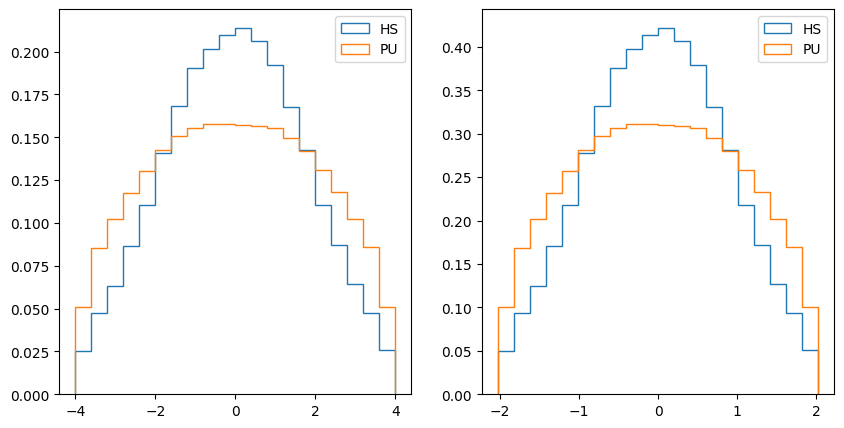

Mean Before:  0.0018320957991763824 		 Mean After:  9.858843719882015e-18
STD Before:  1.9737618567042454 		 STD After:  0.9999999999995943


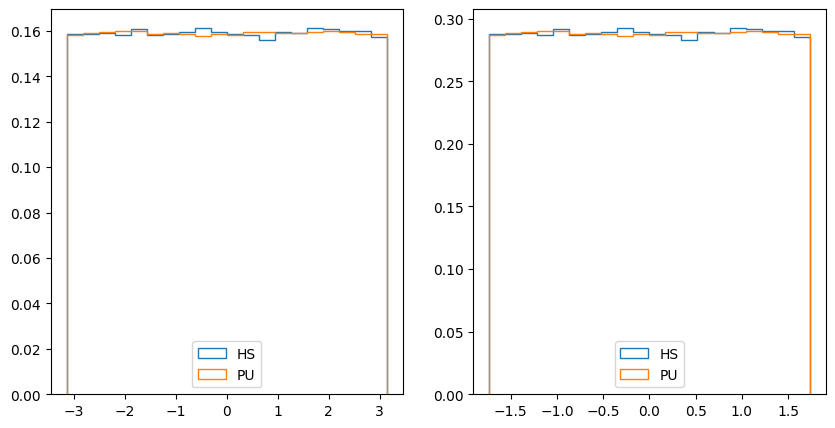

Mean Before:  0.0004835998664490917 		 Mean After:  7.936259519795023e-18
STD Before:  1.8136750086139162 		 STD After:  0.999999999999609


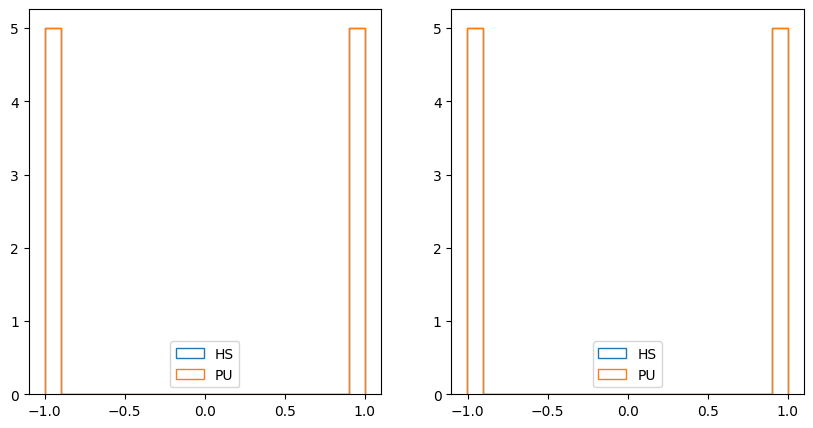

Mean Before:  0.0011850300502758398 		 Mean After:  8.08334306141704e-15
STD Before:  0.9999992978516434 		 STD After:  0.9999999999658901


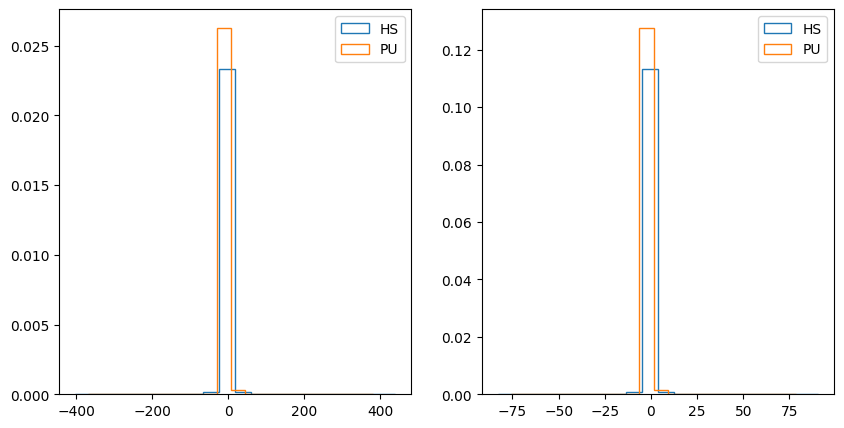

Mean Before:  0.0008441816221650927 		 Mean After:  9.90750532637518e-18
STD Before:  4.856964911584523 		 STD After:  0.9999999999999615


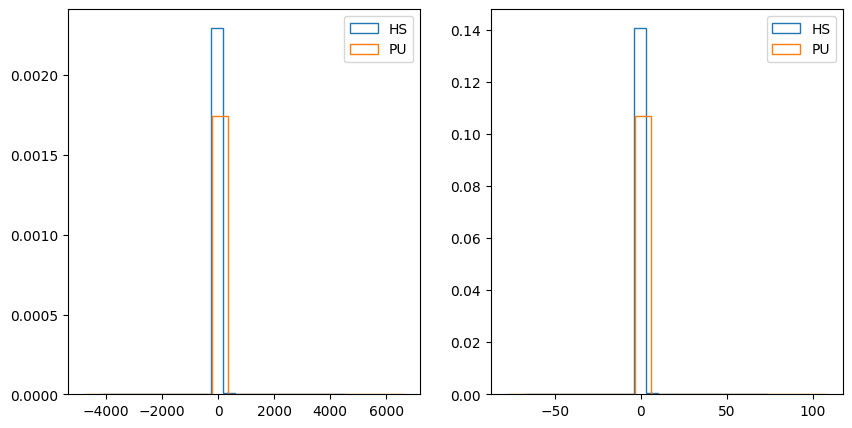

Mean Before:  -0.14999791155261702 		 Mean After:  1.1419454806366605e-16
STD Before:  61.30163100616026 		 STD After:  0.9999999999996885


In [7]:
num_trk_feats = len(refined_tracks[0][0][0])-1

sig = refined_tracks[:,:,:,-1]==-1
bkg = ~sig

norm_list = []
for i in range(num_trk_feats):
    feat = refined_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
norm_list.append(refined_tracks[:,:,:,-1])
    
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
refined_tracks = ak.concatenate(Norm_list, axis=3)

In [8]:
all_tracks = ak.flatten(refined_tracks, axis=2)

print("Jet Shape:\t", selected_jets.type)
print("Trk_Jet  Shape:\t", refined_tracks.type)
print("Trk_All Shape:\t", all_tracks.type)

Jet Shape:	 10000 * var * 7 * float64
Trk_Jet  Shape:	 10000 * var * var * 7 * float64
Trk_All Shape:	 10000 * var * 7 * float64


In [9]:
# Generate List of torch tensors on event by event basis
# Pad number of tracks per jet 

num_events = len(selected_jets)

Event_Data = []
Event_Labels = []

for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    
    num_trks = ak.num(refined_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)

    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(refined_tracks[event][jet,:])
        pad = (0,0,0,max_num_trks-len(tracks))
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    
    # Append all data but don't include label 0:-1!
    flat_tracks = torch.Tensor(all_tracks[event][:,0:-1])
    Event_Data.append((jets[:,0:-1],tracks[:,:,0:-1],flat_tracks))
    #Event_Labels.append((jets[:,-1].reshape(-1,1),tracks[:,:,-1].reshape(-1,1)))
    Event_Labels.append(jets[:,-1].reshape(-1,1))

print("Processing: ", num_events, " / ", num_events)

Processing:  10000  /  10000


In [10]:
train_split = int(0.7*num_events)  # 70% train
test_split = int(0.75*num_events)  #  5% val + 25% test

Event_List = list(zip(Event_Data, Event_Labels))

Events_training = Event_List[0:train_split]
Events_validation = Event_List[train_split:test_split]
Events_testing = Event_List[test_split:]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

Processing:  10000  /  10000
Training Events:  7000
Validation Events:  500
Testing Events:  2500


In [11]:
X_train, y_train = list(zip(*Events_training))
X_val, y_val = list(zip(*Events_validation))
X_test, y_test = list(zip(*Events_testing))

data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle.dump(data, open("data_bce.pkl", "wb"))

In [12]:
print("X_train Indices Reference:")
print("\tNum Events: ", len(X_train))
print("\tNum Tensors: ", len(X_train[0]), "(Jet, trk-jet, flat trk)")
print("\tNum Jets: ", len(X_train[0][0]))
print("\tNum Trks per Jet: ", len(X_train[0][1][0]))
print("\tNum Flat Trks: ", len(X_train[0][2]))
print("\tNum Jet Feats: ", len(X_train[0][0][0]))
print("\tNum Trk Feats: ", len(X_train[0][1][0][0]))
print()
print("y_train Indices Reference:")
print("\tNum Events: ", len(y_train))
print("\tNum Jets: ", len(y_train[0]))

X_train Indices Reference:
	Num Events:  7000
	Num Tensors:  3 (Jet, trk-jet, flat trk)
	Num Jets:  19
	Num Trks per Jet:  24
	Num Flat Trks:  299
	Num Jet Feats:  6
	Num Trk Feats:  6

y_train Indices Reference:
	Num Events:  7000
	Num Jets:  19


In [13]:
# Shuffle
# Split train, val, test
# Calc train mean and std
# Norm train, val, test
# Split batches
# Pad jets and tracks in batches

In [14]:
"""
# Shuffle and pad the tracks and jets
num_events = len(selected_jets)

for event in range(1):
    num_jets = len(selected_jets[event])
    num_trks = ak.num(refined_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    print(max_num_trks)
    
    
    for jet in range(num_jets):
        p = np.random.permutation(len(refined_tracks[event][jet]))
        tmp = refined_tracks[event][jet][p]
        #print(tmp.show())
        tmp = ak.pad_none(tmp,max_num_trks,axis=0)
        tmp = ak.pad_none(tmp,7,axis=1)
        tmp = ak.fill_none(tmp, 0)
        print(jet)
        print(tmp.show())

    p = np.random.permutation(len(selected_jets[event]))
    tmp = selected_jets[event][p]
    tmp = refined_tracks[event][p]
    
# Pad num tracks per jet on event basis
num_events = len(selected_jets)
print(num_events)
for event in range(1):
    len_list = []
    num_jets = len(selected_jets[event])
    num_trks = ak.num(refined_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    print(max_num_trks)
    
    print(refined_tracks[event].show)
    pad = ak.pad_none(refined_tracks[event], max_num_trks, axis=1).to_list()
    print(pad[1][-1])
    pad2 = ak.fill_none(pad,0).to_list()
    #print(pad2)
    print(pad2[1][-1])

    pad = ak.pad_none(pad, 7, axis=1)
    print(pad)
    print(pad[-1])
    tmp = ak.pad_none(pad,7,axis=1)
    print(pad)
    print(pad[-1])
"""

'\n# Shuffle and pad the tracks and jets\nnum_events = len(selected_jets)\n\nfor event in range(1):\n    num_jets = len(selected_jets[event])\n    num_trks = ak.num(refined_tracks[event], axis=1)\n    max_num_trks = ak.max(num_trks)\n    print(max_num_trks)\n    \n    \n    for jet in range(num_jets):\n        p = np.random.permutation(len(refined_tracks[event][jet]))\n        tmp = refined_tracks[event][jet][p]\n        #print(tmp.show())\n        tmp = ak.pad_none(tmp,max_num_trks,axis=0)\n        tmp = ak.pad_none(tmp,7,axis=1)\n        tmp = ak.fill_none(tmp, 0)\n        print(jet)\n        print(tmp.show())\n\n    p = np.random.permutation(len(selected_jets[event]))\n    tmp = selected_jets[event][p]\n    tmp = refined_tracks[event][p]\n    \n# Pad num tracks per jet on event basis\nnum_events = len(selected_jets)\nprint(num_events)\nfor event in range(1):\n    len_list = []\n    num_jets = len(selected_jets[event])\n    num_trks = ak.num(refined_tracks[event], axis=1)\n    max_nu